In [ ]:
import pandas as pd
import os

folder = "../isochrones/travel_times_new"
files = os.listdir(folder)
start_stations = set([int(f.split("_")[2]) for f in files if f.endswith(".csv")])
stations_df = (
    pd.read_csv(
        "../../data/trainline/stations.csv",
        sep=";",
        usecols=["name", "latitude", "longitude", "uic", "info:en"],
    )
    .reset_index()
    .rename(columns={"index": "id"})
)
stations_df = stations_df.dropna(subset=["latitude", "longitude", "uic", "name"])
stations_df["uic"] = stations_df["uic"].astype(int)

In [ ]:
df_motis, df_car, df_train = pd.DataFrame(columns=["start", "end", "time"]), pd.DataFrame(
    columns=["start", "end", "time"]
), pd.DataFrame(columns=["start", "end", "time"])
for file in files:
    if file.endswith(".csv") and file.startswith("travel_times"):
        start_station_id, timestamp, travel_type = file[len("travel_times_"):-4].split("_")
        start_station_id = int(start_station_id)

        travel_times = pd.read_csv(os.path.join(folder, file), usecols=['destination_station_id', 'duration_seconds', 'start_time_isoformat', 'transfers'])
        travel_times = travel_times.dropna(subset=['duration_seconds'])
        travel_times = travel_times[travel_times['duration_seconds'] > 0]

        if travel_type == 'car':
            df_car = pd.concat([df_car, travel_times.rename(columns={'destination_station_id': 'end', 'duration_seconds': 'time'}).assign(start=start_station_id)])
        elif travel_type == 'train':
            df_train = pd.concat([df_train, travel_times.rename(columns={'destination_station_id': 'end', 'duration_seconds': 'time'}).assign(start=start_station_id)])
    elif file.endswith(".csv") and file.startswith("travel_itineraries"):
        start_station_id, timestamp, travel_type = file[len("travel_itineraries_"):-4].split("_")
        start_station_id = int(start_station_id)

        travel_times = pd.read_csv(os.path.join(folder, file), usecols=['destination_station_id', 'duration_seconds', 'start_time_isoformat', 'transfers'])
        travel_times = travel_times.dropna(subset=['duration_seconds'])
        travel_times = travel_times[travel_times['duration_seconds'] > 0]

        if travel_type == 'motis':
            df_motis = pd.concat([df_motis, travel_times.rename(columns={'destination_station_id': 'end', 'duration_seconds': 'time'}).assign(start=start_station_id)])

In [322]:
# keep only the shortest duration for duplicate start-end pairs
df_motis = df_motis.sort_values('time').drop_duplicates(subset=['start', 'end'], keep='first')
df_car = df_car.sort_values('time').drop_duplicates(subset=['start', 'end'], keep='first')
df_train = df_train.sort_values('time').drop_duplicates(subset=['start', 'end'], keep='first')

In [323]:
len(df_car), len(df_train), len(df_motis)

(182708, 451218, 264589)

In [327]:
# drop duplicates (keep shortest travel time)
df_motis = df_motis.sort_values("time").drop_duplicates(["start", "end"])
df_car = df_car.sort_values("time").drop_duplicates(["start", "end"])
df_train = df_train.sort_values("time").drop_duplicates(["start", "end"])

In [328]:
columns_to_merge = ["id", "name", "latitude", "longitude"]

df_motis = df_motis.merge(stations_df[columns_to_merge], left_on="start", right_on="id").drop(columns=["id"]).rename(columns={"name": "start_name", "latitude": "start_latitude", "longitude": "start_longitude"})
df_motis = df_motis.merge(stations_df[columns_to_merge], left_on="end", right_on="id").drop(columns=["id"]).rename(columns={"name": "end_name", "latitude": "end_latitude", "longitude": "end_longitude"})

df_car = df_car.merge(stations_df[columns_to_merge], left_on="start", right_on="id").drop(columns=["id"]).rename(columns={"name": "start_name", "latitude": "start_latitude", "longitude": "start_longitude"})
df_car = df_car.merge(stations_df[columns_to_merge], left_on="end", right_on="id").drop(columns=["id"]).rename(columns={"name": "end_name", "latitude": "end_latitude", "longitude": "end_longitude"})

df_train = df_train.merge(stations_df[columns_to_merge], left_on="start", right_on="id").drop(columns=["id"]).rename(columns={"name": "start_name", "latitude": "start_latitude", "longitude": "start_longitude"})
df_train = df_train.merge(stations_df[columns_to_merge], left_on="end", right_on="id").drop(columns=["id"]).rename(columns={"name": "end_name", "latitude": "end_latitude", "longitude": "end_longitude"})

In [329]:
bbox = (-34.49296,29.635548,46.75348,81.47299) # european bounding box: (xmin, ymin, xmax, ymax)

incorrect_stations = df_train[(df_train['end_latitude'] < bbox[1]) | (df_train['end_latitude'] > bbox[3]) | (df_train['end_longitude'] < bbox[0]) | (df_train['end_longitude'] > bbox[1])]
incorrect_stations = pd.concat([incorrect_stations, df_train[(df_train['start_latitude'] < bbox[1]) | (df_train['start_latitude'] > bbox[3]) | (df_train['start_longitude'] < bbox[0]) | (df_train['start_longitude'] > bbox[1])]])
df_train = df_train[~df_train.index.isin(incorrect_stations.index)]
print(f"Removed {len(incorrect_stations)} train travel times that are outside of the european bounding box")

Removed 217 train travel times that are outside of the european bounding box


In [330]:
# remove all trips that are less than 30 seconds
incorrect_stations = df_train[df_train['time'] < 30]
df_train = df_train[~df_train.index.isin(incorrect_stations.index)]
print(f"Removed {len(incorrect_stations)} train travel times that are less than 30 seconds")

Removed 44 train travel times that are less than 30 seconds


In [331]:
import geopandas as gpd

world = gpd.read_file("https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip")
europe = world[world['CONTINENT'] == 'Europe']
# exclude Russia and other non-EU countries
europe = europe[~europe['NAME'].isin(['Russia', 'Greenland'])]
# Define the bounding box for the EU region
xlim = (-10, 40)
ylim = (35, 70)

In [332]:
import json
import requests
import io
import csv
from geopy.distance import geodesic
from scipy.spatial import cKDTree

# Function to load airport data
def load_openflights_airports(filepath):
    response = requests.get(filepath)
    response.raise_for_status()
    csvfile = io.StringIO(response.text)
    
    airports = {}
    reader = csv.reader(csvfile)
    for row in reader:
        if row[4] == "\\N" or not row[4]:
            continue
        airports[row[4]] = {
            "id": row[0],
            "name": row[1],
            "city": row[2],
            "country": row[3],
            "iata": row[4],
            "icao": row[5],
            "latitude": float(row[6]),
            "longitude": float(row[7]),
        }
    return airports

# Load airport data
airports_data = load_openflights_airports('https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat')

# Load flight data
flight_data = json.load(open("flights_cache_all.json"))

# Build KDTree for stations
stations_tree_start = cKDTree(df_motis[['start_latitude', 'start_longitude']].values)
stations_tree_end = cKDTree(df_motis[['end_latitude', 'end_longitude']].values)

# Function to find the nearest station using KDTree
def find_nearest_station(airport_lat, airport_lon, stations_df, stations_tree):
    distance, idx = stations_tree.query([airport_lat, airport_lon])
    nearest_station = stations_df.iloc[idx]
    return nearest_station

# Create a list to store the results
results = []

for date in flight_data:
    for start_airport_code in flight_data[date]:
        start_airport = airports_data[start_airport_code]
        start_station = find_nearest_station(start_airport['latitude'], start_airport['longitude'], df_motis, stations_tree_start)
        if start_station is None:
            continue
        for end_airport_code in flight_data[date][start_airport_code]:
            end_airport = airports_data[end_airport_code]
            end_station = find_nearest_station(end_airport['latitude'], end_airport['longitude'], df_motis, stations_tree_end)
            if end_station is None:
                continue
            results.append({
                "date": date,
                "start": start_station['start'],
                "start_airport": start_airport_code,
                "start_latitude": start_airport['latitude'],
                "start_longitude": start_airport['longitude'],
                "end_latitude": end_airport['latitude'],
                "end_longitude": end_airport['longitude'],
                "end": end_station['end'],
                "end_airport": end_airport_code,
                "start_name": start_airport['name'],
                "end_name": end_airport['name'],
                "time": flight_data[date][start_airport_code][end_airport_code]
            })

def estimated_total_travel_time(flight_duration_hours, pre_departure=1.5*3600, post_arrival=0.5*3600):
    """
    Estimates the total travel time from arriving at the departure airport
    to leaving the arrival airport.

    Parameters:
        flight_duration_hours (float): The scheduled flight time in hours.
        pre_departure (float): Time (in hours) to arrive before the flight 
                               (default is 1.5 hours for check-in/security).
        post_arrival (float): Time (in hours) after landing to exit the arrival airport 
                              (default is 0.5 hours for deplaning/baggage).

    Returns:
        total_time (float): The estimated total travel time in hours.
    """
    total_time = pre_departure + flight_duration_hours + post_arrival
    return total_time

df_flights = pd.DataFrame(results)
df_flights['time'] = df_flights['time'].apply(estimated_total_travel_time)
df_flights

,date,start,start_airport,start_latitude,start_longitude,end_latitude,end_longitude,end,end_airport,start_name,end_name,time
0,2025/03/11,20587,VIE,48.110298,16.569700,50.901402,4.484440,15889,BRU,Vienna International Airport,Brussels Airport,13500.0
1,2025/03/11,20587,VIE,48.110298,16.569700,50.033333,8.570556,5308,FRA,Vienna International Airport,Frankfurt am Main Airport,12300.0
2,2025/03/11,20587,VIE,48.110298,16.569700,53.630402,9.988230,10078,HAM,Vienna International Airport,Hamburg Airport,12900.0
3,2025/03/11,20587,VIE,48.110298,16.569700,50.865898,7.142740,6014,CGN,Vienna International Airport,Cologne Bonn Airport,12900.0
4,2025/03/11,20587,VIE,48.110298,16.569700,51.289501,6.766780,14834,DUS,Vienna International Airport,Düsseldorf Airport,12900.0
...,...,...,...,...,...,...,...,...,...,...,...,...
367,2025/03/11,26532,HEL,60.317200,24.963301,36.674900,-4.499110,21566,AGP,Helsinki Vantaa Airport,Málaga Airport,20700.0
368,2025/03/11,26532,HEL,60.317200,24.963301,49.012798,2.550000,7252,CDG,Helsinki Vantaa Airport,Charles de Gaulle International Airport,14700.0
369,2025/03/11,26532,HEL,60.317200,24.963301,45.673901,9.704170,19378,BGY,Helsinki Vantaa Airport,Il Caravaggio International Airport,15300.0
370,2025/03/11,26532,HEL,60.317200,24.963301,41.800278,12.238889,17899,FCO,Helsinki Vantaa Airport,Leonardo da Vinci–Fiumicino Airport,16200.0


In [333]:
df_flights.start_airport.unique()

array(['VIE', 'BRU', 'CRL', 'SOF', 'ZAG', 'PRG', 'CPH', 'TLL', 'HEL'],
      dtype=object)

In [334]:
# remove flights outside of Europe:
df_flights.end_airport.unique()
# ['BRU', 'FRA', 'HAM', 'CGN', 'DUS', 'MUC', 'LEJ', 'STR', 'HAJ',
#    'HEL', 'MAN', 'LGW', 'LHR', 'STN', 'AMS', 'EIN', 'DUB', 'CPH',
#    'LUX', 'KRK', 'WAW', 'ARN', 'TIA', 'SOF', 'VAR', 'ZAG', 'ALC',
#    'BCN', 'MAD', 'AGP', 'VLC', 'SVQ', 'LYS', 'NCE', 'BVA', 'CDG',
#    'BSL', 'SKG', 'BUD', 'BRI', 'CTA', 'MXP', 'BGY', 'BLQ', 'TSF',
#    'VCE', 'FCO', 'NAP', 'PRG', 'MLA', 'GRZ', 'INN', 'FAO', 'OPO',
#    'LIS', 'SJJ', 'OTP', 'GVA', 'ZRH', 'ACH', 'AYT', 'KIV', 'SKP',
#    'BEG', 'TGD', 'PRN', 'KSC', 'ATH', 'RIX', 'PMI', 'SAW', 'KLU',
#    'IST', 'TUN', 'BHX', 'OSL', 'GOT', 'AHU', 'TNG', 'BIO', 'TLS',
#    'MRS', 'LIN', 'RVN', 'EDI', 'DBV', 'GRO', 'CCF', 'BZR', 'PSR',
#    'PMO', 'TRN', 'CIA', 'PSA', 'CRA', 'IAS', 'TSR', 'CDT', 'NUE',
#    'DTM', 'LTN', 'FMM', 'PUY', 'SPU', 'OMO', 'BFS', 'BRS', 'ORY',
#    'TLL', 'AAR', 'KRP', 'RNN', 'SGD', 'FAE', 'AAL', 'BGO', 'TOS',
#    'TRF', 'TRD', 'SVG', 'GDN', 'POZ', 'PLQ', 'VNO', 'KDL', 'URE',
#    'TMP', 'TAY', 'IVL', 'JOE', 'JYV', 'KEM', 'KAJ', 'KOK', 'KAO',
#    'KTT', 'KUO', 'MHQ', 'OUL', 'VAA']
# remove: TUN (Tunisia), AYT (Turkey), IST (Turkey), SAW (Turkey), TNG (Morocco), AHU (Morocco), FAE (Faroe Islands)
df_flights = df_flights[~df_flights['end_airport'].isin(['TUN', 'AYT', 'IST', 'SAW', 'TNG', 'AHU', 'FAE'])]


In [335]:
len(df_flights)

350

In [336]:
start_stations = df_motis['start'].unique()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import timezonefinder

for start_station in start_stations:
    print(f"Plotting travel times for {stations_df.loc[start_station]['name']} ({start_station})")
    # Create a function to plot the data
    def plot_travel_times(df, start_station, title, ax, vmin, vmax, size=2):
        # Plot the base map
        europe.plot(ax=ax, color='white', edgecolor='black')
        df = df[df['start'] == start_station]
        
        # Plot the travel times
        sc = ax.scatter(df['end_longitude'], df['end_latitude'], c=df['time'], cmap='YlOrRd', norm=Normalize(vmin=vmin, vmax=vmax), s=size)
        # Plot the start station with the name next to it
        start_station = df[df['start'] == start_station].iloc[0]
        ax.scatter(start_station['start_longitude'], start_station['start_latitude'], color='blue', s=7)
        ax.text(start_station['start_longitude'], start_station['start_latitude'], start_station['start_name'], fontsize=8)
        
        # Set the title and limits
        ax.set_title(title)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        
        # Add color bar
        cbar = plt.colorbar(ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), cmap='YlOrRd'), ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Travel Time (hours)')
        cbar.set_ticks([3600 * i for i in range(0, int(vmax // 3600) + 1)])
        cbar.set_ticklabels([f'{i}h' for i in range(0, int(vmax // 3600) + 1)])

    max_time = 3600 * 8.1

    # Plot each dataframe
    tf = timezonefinder.TimezoneFinder()

    # Find the timezone
    station = df_motis[df_motis['start'] == start_station].iloc[0]
    timezone_str = tf.timezone_at(lng=station.start_longitude, lat=station.start_latitude)
    start_date = df_motis[df_motis['start'] == start_station].sort_values('time').iloc[0]['start_time']
    start_date = pd.to_datetime(start_date)
    start_date_local = start_date.tz_convert(timezone_str)

    dataframes = [
        {'df': df_train, 'plot_name': 'Train infrastructure Travel Times (theoretical)'},
        {'df': df_motis, 'plot_name': f'Motis Travel Times (starting {start_date_local.strftime("%Y-%m-%d %H:%M %Z")})'},
        {'df': df_car, 'plot_name': 'Car Travel Times (no traffic, no breaks)'},
        {'df': df_flights, 'plot_name': 'Flight Travel Times (including 2h check-in and security)', 'size': 10}
    ]
    for df in dataframes:
        df['df'] = df['df'][df['df']['time'] <= max_time]
    # Determine the global min and max travel times
    vmin = min(df['df']['time'].min() for df in dataframes)
    vmax = max(df['df']['time'].max() for df in dataframes)

    # only take the dataframs that contain the start station
    dataframes = [df for df in dataframes if start_station in df['df']['start'].values]
    # Create the figure and axes
    fig, axs = plt.subplots(1, len(dataframes), figsize=(20, 10))

    for i, df in enumerate(dataframes):
        if len(dataframes) == 1:
            axs = [axs]
        plot_travel_times(df['df'], start_station, df['plot_name'], axs[i], vmin, vmax, df.get('size', 2))

    # Show the plot
    plt.tight_layout()
    # remove axes labels
    for ax in axs:
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks([])
        ax.set_yticks([])
    # save as pdf
    plt.savefig(f"figures/travel_times_{stations_df.loc[start_station]['name']}.pdf", bbox_inches='tight', dpi=300)
    plt.show()

In [338]:
def build_geojson_dict(df, key_col, dest_lon, dest_lat, time_col):
    # Returns dict: start_id -> list of {lon, lat, time}
    out = {}
    for start_id, grp in df.groupby(key_col):
        # Add the station itself as the first point
        station_row = grp.iloc[0]
        station_point = {
            dest_lon: station_row['start_longitude'],
            dest_lat: station_row['start_latitude'],
            time_col: 0  # Time to itself is 0
        }
        pts = [station_point] + grp[[dest_lon, dest_lat, time_col]].to_dict(orient="records")
        out[start_id] = pts
    return out

# build per‐mode dicts (if you want to show multiple modes separately)
train_tt = build_geojson_dict(df_train, "start", "end_longitude", "end_latitude", "time")
motis_tt = build_geojson_dict(df_motis, "start", "end_longitude", "end_latitude", "time")
car_tt   = build_geojson_dict(df_car,   "start", "end_longitude", "end_latitude", "time")
flight_tt = build_geojson_dict(df_flights, "start", "end_longitude", "end_latitude", "time")

# merge into one structure
all_modes = {
    "train": train_tt,
    "motis": motis_tt,
    "car": car_tt,
    "flight": flight_tt
}

with open("leaflet_travel_times.json", "w") as f:
    json.dump(all_modes, f)


In [339]:
population_df = pd.read_csv("trainline_stations_with_population.csv", dtype={'id': 'int64', 'name': 'object', 'uic': 'float64', 'latitude': 'float64', 'longitude': 'float64', 'country': 'object', 'population': 'float64', 'closest_city_id': 'float64', 'distance_km': 'float64'})

In [340]:
big_cities = population_df[population_df['population'] > 1_000_000]
# remove cities in country TR
big_cities = big_cities[big_cities['country'] != 'TR']
start_stations = big_cities['id'].unique()

# Step 2: Find canonical station (closest to city) for each closest_city_id
canonical_stations = (
    big_cities
    .sort_values('distance_km')  # sort so closest is first
    .drop_duplicates('closest_city_id')  # keep only the closest one
    .set_index('closest_city_id')
)
# rename Châtelet to Paris
canonical_stations.loc[canonical_stations.id == 15290, 'name'] = 'Paris'
canonical_stations.loc[canonical_stations.id == 17123, 'name'] = 'Stockholm Central'

In [341]:
canonical_stations

,id,name,uic,latitude,longitude,country,population,distance_km
closest_city_id,,,,,,,,
3918.0,63986,Madrid Sol,7118101.0,0.705408,-0.064633,ES,3277451.0,0.012722
524.0,4989,Barcelona,7199998.0,0.722257,0.038003,ES,1627559.0,0.044715
651.0,14724,Berlin Brandenburger Tor,8003057.0,0.916586,0.233557,DE,3632853.0,0.104005
1296.0,5921,Köln Hbf,8015458.0,0.889124,0.121453,DE,1021253.0,0.111757
4279.0,10837,München Isartor,8020554.0,0.840098,0.202166,DE,1490516.0,0.122482
3784.0,6617,London Charing Cross,7051430.0,0.898991,-0.002161,GB,8908081.0,0.283550
723.0,6527,Birmingham New Street,7011270.0,0.915917,-0.033133,GB,1157603.0,0.346729
5002.0,15290,Paris,8797807.0,0.852738,0.040965,FR,2104154.0,0.414276
2336.0,10347,Hamburg Jungfernstieg,8001049.0,0.934662,0.174426,DE,1832675.0,0.471973


In [342]:
# Save only end stations that are also in the start stations
train_capitals = df_train[df_train['end'].isin(start_stations)]
motis_capitals = df_motis[df_motis['end'].isin(start_stations)]
car_capitals = df_car[df_car['end'].isin(start_stations)]

In [ ]:
# Step 3: Create a mapping of all station ids in each city to the closest station's id
station_to_canonical = population_df.set_index('id')['closest_city_id'].map(canonical_stations['id'])

# Drop NAs just in case
station_to_canonical = station_to_canonical.dropna().astype(int)

# Step 4: Function to update IDs, names, and coordinates in a timetable dataframe
def update_df(df, stations_df, station_to_canonical):
    for col in ['start', 'end']:
        df[col] = df[col].map(station_to_canonical).fillna(df[col]).astype(int)
    
    for prefix in ['start', 'end']:
        id_col = df[f'{prefix}']
        df[f'{prefix}_name'] = id_col.map(
            stations_df.set_index('id')['name']
        )
        df[f'{prefix}_latitude'] = id_col.map(
            stations_df.set_index('id')['latitude']
        )
        df[f'{prefix}_longitude'] = id_col.map(
            stations_df.set_index('id')['longitude']
        )

    df = df[df['start'] != df['end']]
    return df

# Step 5: Apply updates
train_capitals = update_df(train_capitals, stations_df, station_to_canonical)
motis_capitals = update_df(motis_capitals, stations_df, station_to_canonical)
car_capitals = update_df(car_capitals, stations_df, station_to_canonical)


In [344]:
train_tt = build_geojson_dict(train_capitals, "start", "end_longitude", "end_latitude", "time")
motis_tt = build_geojson_dict(motis_capitals, "start", "end_longitude", "end_latitude", "time")
car_tt   = build_geojson_dict(car_capitals,   "start", "end_longitude", "end_latitude", "time")

# merge into one structure
all_modes = {
    "train": train_tt,
    "motis": motis_tt,
    "car": car_tt,
}

with open("leaflet_capitals_travel_times.json", "w") as f:
    json.dump(all_modes, f)

In [345]:
# find sodertälje station
train_capitals.end_name.unique()

array(['Praha Masarykovo n.', 'Södertälje Syd station', 'Wien Mitte',
       'Châtelet', 'Hamburg Jungfernstieg', 'Köln Hbf',
       'London Charing Cross', 'Budapest-Déli', 'Milano Porta Garibaldi',
       'Minsk-Passajirskii', 'Birmingham New Street', 'Barcelona',
       'Berlin Brandenburger Tor', 'München Isartor',
       'Warszawa Zachodnia', 'Beograd', 'Roma Termini', 'Madrid Sol',
       'București Nord'], dtype=object)

In [346]:
# rename change start == 15534 to start == 20931
train_capitals.loc[train_capitals['start'] == 15534, 'start'] = 20931
motis_capitals.loc[motis_capitals['start'] == 15534, 'start'] = 20931
car_capitals.loc[car_capitals['start'] == 15534, 'start'] = 20931

# rename "Châtelet" to "Paris"
train_capitals.loc[train_capitals['start_name'] == "Châtelet", 'start_name'] = "Paris"
train_capitals.loc[train_capitals['end_name'] == "Châtelet", 'end_name'] = "Paris"
motis_capitals.loc[motis_capitals['start_name'] == "Châtelet", 'start_name'] = "Paris"
motis_capitals.loc[motis_capitals['end_name'] == "Châtelet", 'end_name'] = "Paris"
car_capitals.loc[car_capitals['start_name'] == "Châtelet", 'start_name'] = "Paris"
car_capitals.loc[car_capitals['end_name'] == "Châtelet", 'end_name'] = "Paris"

stockholm_central = stations_df[stations_df['name'] == 'Stockholm Central']
# same thing for Södertälje Syd station renaming to Stockholm Central
train_capitals.loc[train_capitals['start_name'] == "Södertälje Syd station", ['start_name', 'start_latitude', 'start_longitude']] = ["Stockholm Central", stockholm_central['latitude'].values[0], stockholm_central['longitude'].values[0]]
train_capitals.loc[train_capitals['end_name'] == "Södertälje Syd station", ['end_name', 'end_latitude', 'end_longitude']] = ["Stockholm Central", stockholm_central['latitude'].values[0], stockholm_central['longitude'].values[0]]
motis_capitals.loc[motis_capitals['start_name'] == "Södertälje Syd station", ['start_name', 'start_latitude', 'start_longitude']] = ["Stockholm Central", stockholm_central['latitude'].values[0], stockholm_central['longitude'].values[0]]
motis_capitals.loc[motis_capitals['end_name'] == "Södertälje Syd station", ['end_name', 'end_latitude', 'end_longitude']] = ["Stockholm Central", stockholm_central['latitude'].values[0], stockholm_central['longitude'].values[0]]
car_capitals.loc[car_capitals['start_name'] == "Södertälje Syd station", ['start_name', 'start_latitude', 'start_longitude']] = ["Stockholm Central", stockholm_central['latitude'].values[0], stockholm_central['longitude'].values[0]]
car_capitals.loc[car_capitals['end_name'] == "Södertälje Syd station", ['end_name', 'end_latitude', 'end_longitude']] = ["Stockholm Central", stockholm_central['latitude'].values[0], stockholm_central['longitude'].values[0]]

# same thing for Praha Masarykovo n. and Praha hl.n.
praha = stations_df[stations_df['name'] == 'Praha hl.n.']
train_capitals.loc[train_capitals['start_name'] == "Praha Masarykovo n.", ['start_name', 'start_latitude', 'start_longitude']] = ["Praha hl.n.", praha['latitude'].values[0], praha['longitude'].values[0]]
train_capitals.loc[train_capitals['end_name'] == "Praha Masarykovo n.", ['end_name', 'end_latitude', 'end_longitude']] = ["Praha hl.n.", praha['latitude'].values[0], praha['longitude'].values[0]]
motis_capitals.loc[motis_capitals['start_name'] == "Praha Masarykovo n.", ['start_name', 'start_latitude', 'start_longitude']] = ["Praha hl.n.", praha['latitude'].values[0], praha['longitude'].values[0]]
motis_capitals.loc[motis_capitals['end_name'] == "Praha Masarykovo n.", ['end_name', 'end_latitude', 'end_longitude']] = ["Praha hl.n.", praha['latitude'].values[0], praha['longitude'].values[0]]
car_capitals.loc[car_capitals['start_name'] == "Praha Masarykovo n.", ['start_name', 'start_latitude', 'start_longitude']] = ["Praha hl.n.", praha['latitude'].values[0], praha['longitude'].values[0]]
car_capitals.loc[car_capitals['end_name'] == "Praha Masarykovo n.", ['end_name', 'end_latitude', 'end_longitude']] = ["Praha hl.n.", praha['latitude'].values[0], praha['longitude'].values[0]]

In [347]:
import networkx as nx
from tqdm import tqdm

def export_travel_times_with_missing_connections(df: pd.DataFrame, output_file: str):
    # Step 1: Create a unique list of locations
    loc_set = set()
    for row in df.itertuples(index=False):
        loc_set.add((row.start_name, row.start_latitude, row.start_longitude))
        loc_set.add((row.end_name, row.end_latitude, row.end_longitude))

    locations = [{"name": name, "lat": lat, "lon": lon} for name, lat, lon in loc_set]
    location_index = { (loc["name"], loc["lat"], loc["lon"]): idx for idx, loc in enumerate(locations) }

    # Step 2: Build the graph
    G = nx.DiGraph()
    for row in df.itertuples(index=False):
        start = location_index[(row.start_name, row.start_latitude, row.start_longitude)]
        end = location_index[(row.end_name, row.end_latitude, row.end_longitude)]
        time = row.time
        G.add_edge(start, end, weight=min(time, G[start][end]["weight"]) if G.has_edge(start, end) else time)
        G.add_edge(end, start, weight=min(time, G[end][start]["weight"]) if G.has_edge(end, start) else time)

    # Step 3: Calculate travel times (with 2400s penalty per transfer)
    travel_times = {}
    for source in tqdm(range(len(locations)), desc="Calculating travel times", leave=False):
        lengths = nx.single_source_dijkstra_path_length(G, source, weight='weight')
        for target, time in lengths.items():
            if source == target:
                continue
            key = f"{min(source, target)}-{max(source, target)}"
            if key not in travel_times or time < travel_times[key]:
                travel_times[key] = time

    # Step 4: Output to JSON
    output_data = {
        "locations": locations,
        "travelTimes": travel_times
    }

    with open(output_file, "w") as f:
        json.dump(output_data, f, indent=2)


# Example usage
export_travel_times_with_missing_connections(train_capitals, "europe_train.json")
export_travel_times_with_missing_connections(motis_capitals, "europe_motis.json")
export_travel_times_with_missing_connections(car_capitals, "europe_car.json")

In [ ]:
def compute_normalised_speed(df):
    df_copy = df.copy()
    df_copy['distance'] = df_copy.apply(lambda x: geodesic((x['start_latitude'], x['start_longitude']), (x['end_latitude'], x['end_longitude'])).kilometers, axis=1)
    df_copy['speed'] = df_copy['distance'] / df_copy['time'] * 3600
    # ignore speed of more than 300 km/h
    df_copy = df_copy[df_copy['speed'] < 300]
    df_speed = df_copy.groupby('end').agg({'speed': 'mean', 'end_latitude': 'first', 'end_longitude': 'first'}).reset_index()
    max_speed = df_speed['speed'].max()
    df_speed['normalised_speed'] = df_speed['speed'] / max_speed

    return df_speed

df_speeds = [
    {'df': compute_normalised_speed(df_train), 'title': 'Train Infrastructure Speeds'},
    {'df': compute_normalised_speed(df_motis), 'title': 'Motis Speeds'},
    {'df': compute_normalised_speed(df_car), 'title': 'Car Speeds'},
]

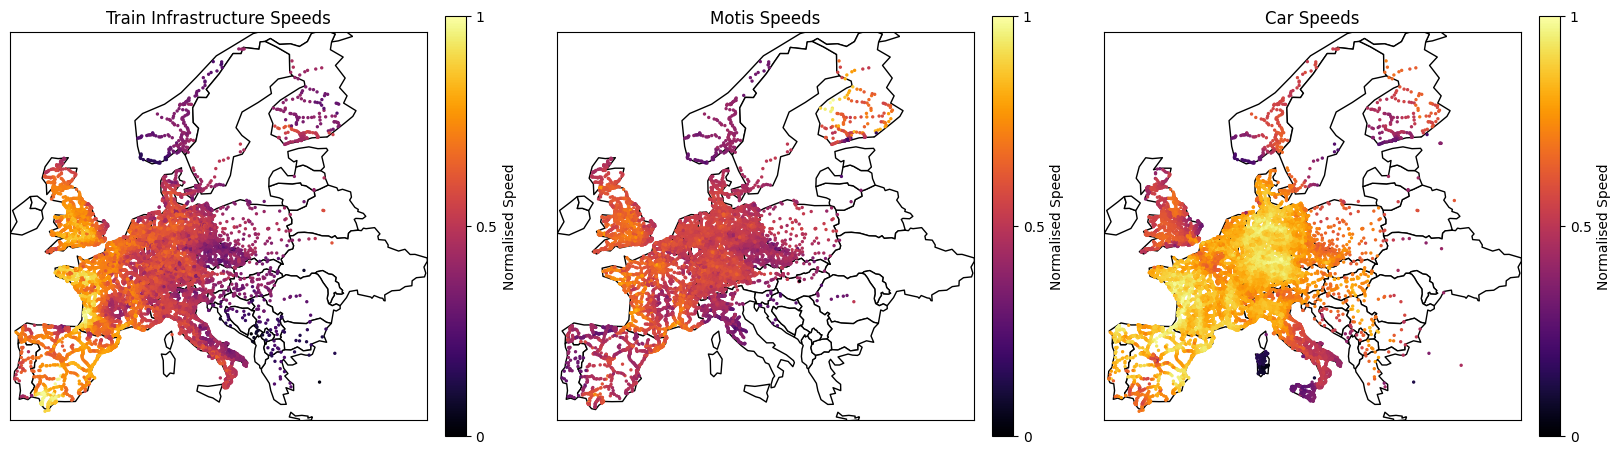

In [ ]:
def plot_normalised_speed(df_speed, title, xlim, ylim, ax, cmap='inferno'):
    europe.plot(ax=ax, color='white', edgecolor='black')
    sc = ax.scatter(df_speed['end_longitude'], df_speed['end_latitude'], c=df_speed['normalised_speed'], cmap=cmap, s=2)
    
    # Set the title and limits
    ax.set_title(title)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Add color bar
    cbar = plt.colorbar(ScalarMappable(norm=Normalize(vmin=0, vmax=1), cmap=cmap), ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Normalised Speed')
    cbar.set_ticks([0, 0.5, 1])
    cbar.set_ticklabels(['0', '0.5', '1'])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_yticks([])


fig, axs = plt.subplots(1, len(df_speeds), figsize=(20, 10))
for i, df in enumerate(df_speeds):
    plot_normalised_speed(df['df'], df['title'], xlim, ylim, axs[i])
plt.savefig(f"figures/normalised_speeds.pdf", bbox_inches='tight', dpi=300)

In [ ]:
mot_speed = df_speeds[1]['df']
mot_speed[mot_speed['normalised_speed'] >= 0.9]

,end,speed,end_latitude,end_longitude,normalised_speed
2000,3269,103.528067,43.732438,4.343474,0.936371
2001,3270,102.747172,43.724503,4.321218,0.929308
2002,3271,101.246103,43.695038,4.270165,0.915731
15550,26563,102.491101,63.100855,23.034937,0.926992
15569,26584,108.4006,63.835940,23.130787,0.980441
15589,26605,105.934229,62.972497,23.014756,0.958134
15640,26664,110.563099,63.596797,22.789891,1.0
15653,26678,105.402614,62.793109,22.843768,0.953325
15664,26689,104.900093,63.001945,22.170734,0.94878
